Team Name: Hamster Herder
Mica Haney (Hamster Herder)

I resourced the documentation for sci-kit learn and tensorflow for this project. This was used as reference materail, rather than a guide. I also referenced the tutorial notebook that was provided.

Links:

*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
*   https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
*   https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
*   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
*   https://www.tensorflow.org/api_docs/python/tf/keras/losses
*   https://www.tensorflow.org/api_docs/python/tf/keras/metrics
*   https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
*   https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint



# Setup

In [1]:
# # Load Kaggle Key --------------------------------------------------------------
# ! pip install -q kaggle
# from google.colab import files
# files.upload()

In [2]:
# # Download Dataset -------------------------------------------------------------
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c csce5300-competition

# Imports and Global Variables

In [3]:
# Imports ----------------------------------------------------------------------
import pandas as pd
from datetime import datetime
import numpy as np
from math import floor, ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import os
import shutil
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge, LogisticRegression, SGDRegressor, Lasso, Ridge, ElasticNet

# Load Data

Data Fields

*   datetime - hourly date + timestamp
*   season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
*   holiday - whether the day is considered a holiday
*   workingday - whether the day is neither a weekend nor holiday
*   weather -
    *   1 - Clear, Few clouds, Partly cloudy, Partly cloudy
    *   2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    *   3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +  Scattered clouds
    *   4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
*   temp - temperature in Celsius
*   atemp - "feels like" temperature in Celsius
*   humidity - relative humidity
*   windspeed - wind speed
*   casual - number of non-registered user rentals initiated
*   registered - number of registered user rentals initiated
*   count - number of total rentals


In [4]:
# Load Files -------------------------------------------------------------------
train = pd.read_csv("train_luc.csv")
test = pd.concat([pd.read_csv("test_luc.csv"), pd.read_csv("sample_prediction.csv").drop("datetime", axis=1)], axis=1)

In [5]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9169,2012-12-16 19:00:00,4,0,0,1,14.76,17.425,93,8.9981,10,99,109
9170,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122
9171,2012-12-16 21:00:00,4,0,0,2,14.76,18.940,93,0.0000,14,92,106
9172,2012-12-16 22:00:00,4,0,0,2,16.40,20.455,82,12.9980,6,83,89


In [6]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013,56.578956
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980,33.765150
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979,22.884537
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980,11.824137
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981,6.371916
...,...,...,...,...,...,...,...,...,...,...
1707,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,315.439922
1708,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,225.342525
1709,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,170.408270
1710,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,133.614087


# Data Processing

In [7]:
# Feature Engineering ----------------------------------------------------------

# Month feature
def get_month(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date().month
train["month"] = train["datetime"].apply(get_month)
test["month"] = test["datetime"].apply(get_month)

# Day feature
def get_day(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date().day
train["day"] = train["datetime"].apply(get_day)
test["day"] = test["datetime"].apply(get_day)

# Hour feature
def get_hour(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").time().hour
train["hour"] = train["datetime"].apply(get_hour)
test["hour"] = test["datetime"].apply(get_hour)

# Windchill feature
# Formula from https://sciencing.com/calculate-wind-chill-factor-5981683.html
def get_windchill(row):
    if row["temp"] < 50 and row["windspeed"] > 3:
        return 13.12 + 0.6215 * row["temp"] - 11.37 * (row["windspeed"]**0.16) + 0.3965 * row["temp"] * (row["windspeed"]**0.16)
    else:
        return 0
train["windchill"] = train.apply(get_windchill, axis=1)
test["windchill"] = test.apply(get_windchill, axis=1)

# Heat index feature
# Formula from https://en.wikipedia.org/wiki/Heat_index#:~:text=For%20example%2C%20using%20this%20last,%2C%20RH%2085%25%20%3D%20114.9.
def get_heat_index(row):
    t = row["temp"]
    h = row["humidity"]
    return -8.78469475556 + \
           1.61139411*t + \
           2.33854883889*h + \
           -0.14611605*t*h + \
           -0.012308094*(t**2) + \
           -0.0164248277778*(h**2) + \
           0.002211732*(t**2)*h + \
           0.00072546*t*(h**2) + \
           -0.000003582*(t**2)*(h**2)
train["heat_idx"] = train.apply(get_heat_index, axis=1)
test["heat_idx"] = test.apply(get_heat_index, axis=1)

In [8]:
# Plot Feature vs. Count -------------------------------------------------------

def plot_scatter(df, feat, step=1):

    # Get data
    x = list(df[feat].values)
    y = list(df["count"].values)

    # Set x-labels
    x_min = floor(min(x))
    x_max = ceil(max(x))
    x_ticks = np.arange(x_min, x_max+step, step)

    # Plot
    plt.scatter(x, y, facecolor="b")
    plt.title("%s vs. Count"%(feat.lower().capitalize()))
    plt.ylabel("Count")
    plt.xlabel(feat.lower().capitalize())
    plt.xticks(x_ticks)
    plt.show()

def plot_occurances(df, feat, step=1):

    # Get data
    vals = list(df[feat].values)
    d = {}
    for v in sorted(vals):
        if v not in d:
            d.update({v: 0})
        d[v] += 1
    x = []
    y = []
    for k in d:
        x.append(k)
        y.append(d[k])
    
    # Set x-labels
    x_min = floor(min(x))
    x_max = ceil(max(x))
    x_ticks = np.arange(x_min, x_max+step, step)

    # Plot
    plt.plot(x, y, marker="o", color="b")
    plt.title("Occurances of %s"%(feat.lower().capitalize()))
    plt.ylabel("Count")
    plt.xlabel(feat.lower().capitalize())
    plt.xticks(x_ticks)
    plt.show()

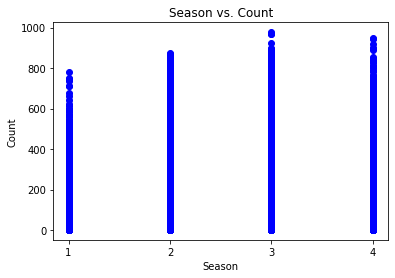

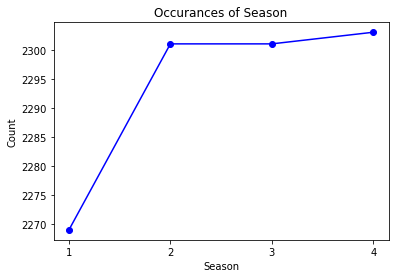

In [9]:
# Season
plot_scatter(train, "season")
plot_occurances(train, "season")

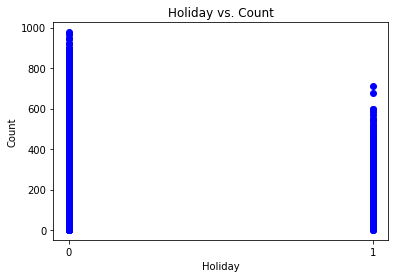

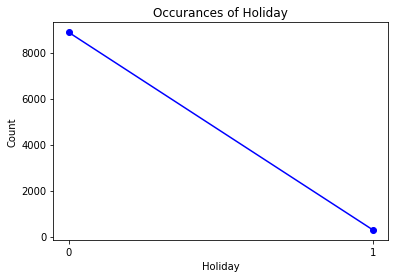

In [10]:
# Holiday
plot_scatter(train, "holiday")
plot_occurances(train, "holiday")

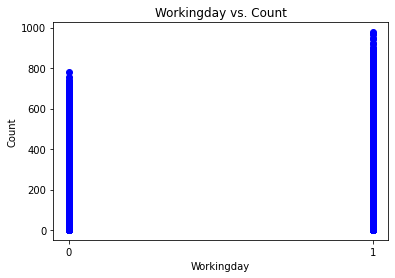

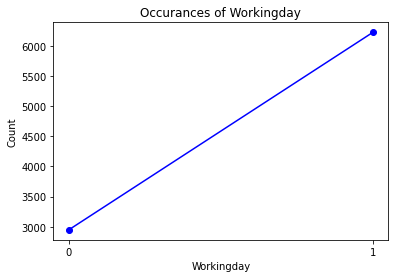

In [11]:
# Working Day
plot_scatter(train, "workingday")
plot_occurances(train, "workingday")

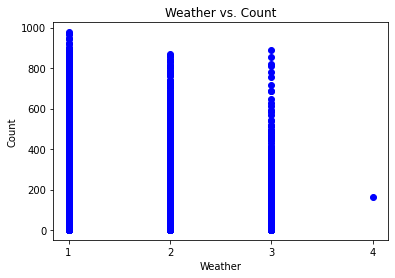

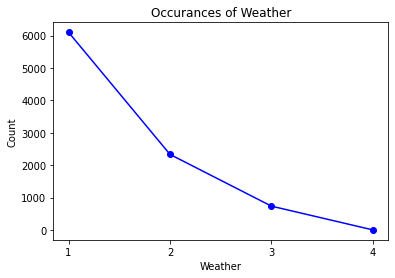

In [12]:
# Weather
plot_scatter(train, "weather")
plot_occurances(train, "weather")

0.82
41.0


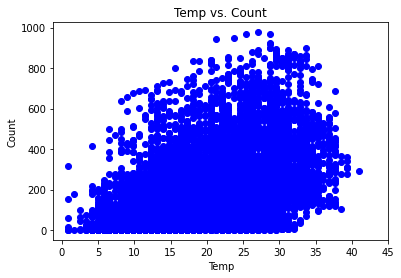

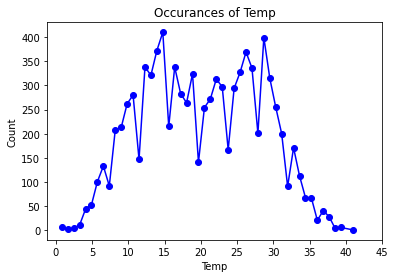

In [13]:
# Temperature
vals = set()
for x in train["temp"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "temp", 5)
plot_occurances(train, "temp", 5)

0.76
45.455


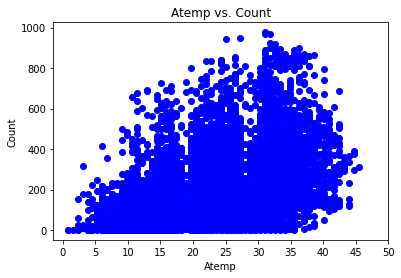

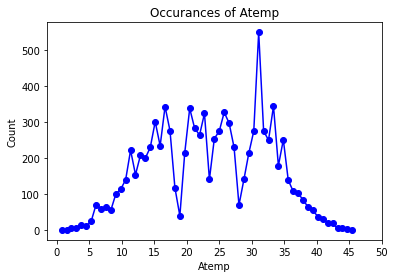

In [14]:
# Feels-Like Temperature
vals = set()
for x in train["atemp"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "atemp", 5)
plot_occurances(train, "atemp", 5)

0
100


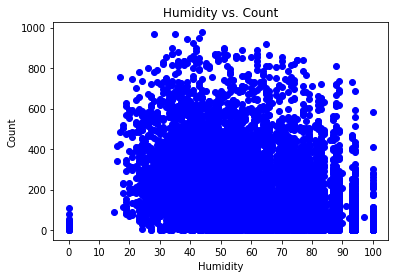

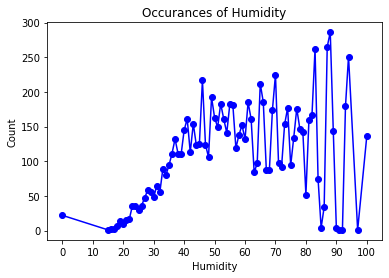

In [15]:
# Humidity
vals = set()
for x in train["humidity"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "humidity", 10)
plot_occurances(train, "humidity", 10)

0.0
56.9969


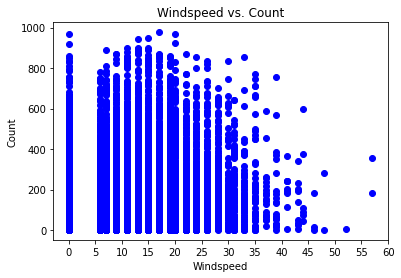

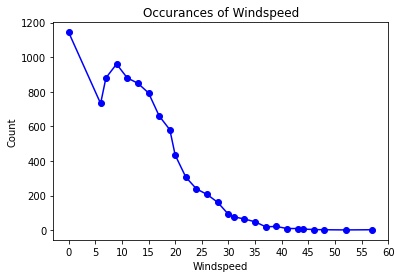

In [16]:
# Windspeed
vals = set()
for x in train["windspeed"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "windspeed", 5)
plot_occurances(train, "windspeed", 5)

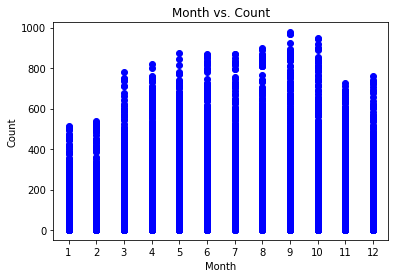

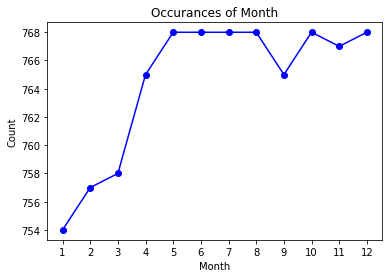

In [17]:
# Month
plot_scatter(train, "month")
plot_occurances(train, "month")

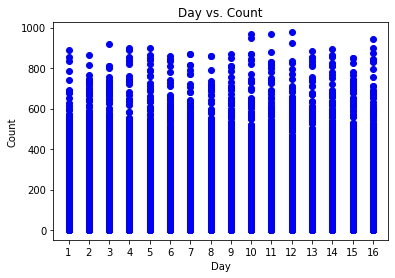

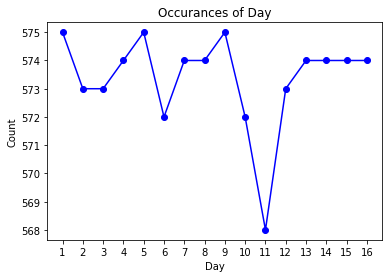

In [18]:
# Day
plot_scatter(train, "day")
plot_occurances(train, "day")

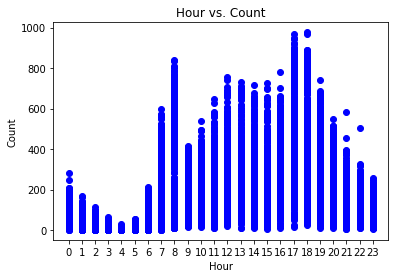

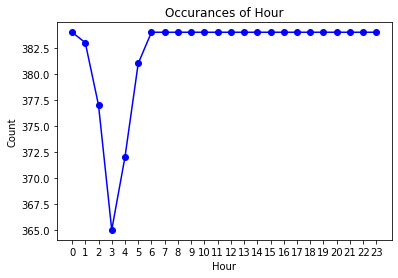

In [19]:
# Hour
plot_scatter(train, "hour")
plot_occurances(train, "hour")

-4.061907331513252
45.77332321985348


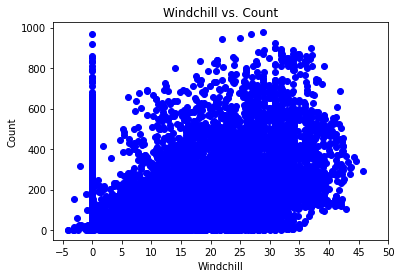

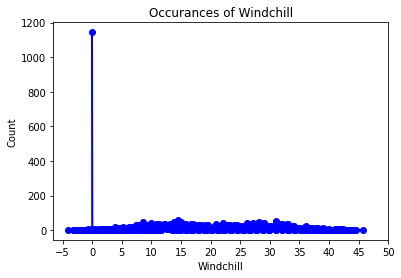

In [20]:
# Windchill
vals = set()
for x in train["windchill"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "windchill", 5)
plot_occurances(train, "windchill", 5)

11.2863860026216
59.56664245178799


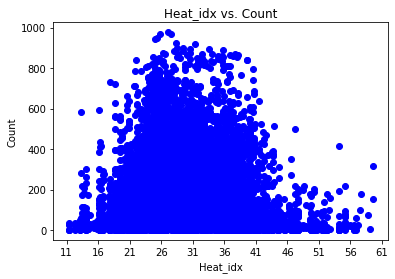

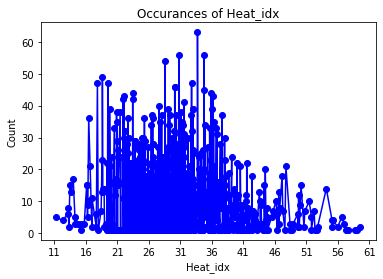

In [21]:
# Heat Index
vals = set()
for x in train["heat_idx"].values:
    vals.add(x)
vals = list(vals)
min_val = min(vals)
max_val = max(vals)
print(min_val)
print(max_val)
plot_scatter(train, "heat_idx", 5)
plot_occurances(train, "heat_idx", 5)

In [22]:
# Feature Preprocessing --------------------------------------------------------

# One-hot encode month, day, hour, and weather
cols = ["month", "day", "hour", "weather"]
enc = OneHotEncoder(handle_unknown="ignore")
vals = train[cols]
vals = enc.fit_transform(vals.to_numpy())
encoded = pd.DataFrame(vals.toarray(), columns=enc.get_feature_names(cols))
train = pd.concat([train, encoded], axis=1)
train.drop(cols, axis=1, inplace=True)

vals = test[cols]
vals = enc.transform(vals.to_numpy())
encoded = pd.DataFrame(vals.toarray(), columns=enc.get_feature_names(cols))
test = pd.concat([test, encoded], axis=1)
test.drop(cols, axis=1, inplace=True)

# Scale humidity
def scale(x):
    return x/100.0
train["humidity"] = train["humidity"].apply(scale)
test["humidity"] = test["humidity"].apply(scale)

In [23]:
# Shuffle Data -----------------------------------------------------------------
train = train.sample(frac=1, random_state=42)
test = test.sample(frac=1, random_state=42)

In [24]:
# Split Data -------------------------------------------------------------------
print("Training Columns:\n", list(train.columns))
print("\nTesting Columns:\n", list(test.columns))

# Get validation
val = train.sample(frac=0.2, random_state=42)
train.drop(val.index, inplace=True)

# Split training
train_y = train[["count"]]
train_x = train.drop(["datetime", "casual", "registered", "count"], axis=1)

# Split validation
val_y = val[["count"]]
val_x = val.drop(["datetime", "casual", "registered", "count"], axis=1)

# Split testing
test_y = test[["count"]]
test_x = test.drop(["datetime", "count"], axis=1)

Training Columns:
 ['datetime', 'season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'windchill', 'heat_idx', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weather_1', 'weather_2', 'weather_3', 'weather_4']

Testing Columns:
 ['datetime', 'season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'windchill', 'heat_idx', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',

In [25]:
train_x

,season,holiday,workingday,temp,atemp,humidity,windspeed,windchill,heat_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_1,weather_2,weather_3,weather_4
6459,2,0,1,26.24,30.305,0.73,8.9981,28.055480,27.790554,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3128,3,0,0,32.80,38.635,0.59,15.0013,36.027237,38.668099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5501,1,0,1,22.14,25.760,0.42,23.9994,22.570959,25.003324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8111,4,0,1,28.70,32.575,0.54,19.0012,30.972347,29.746283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3298,3,0,0,25.42,29.545,0.73,7.0015,27.155959,26.536125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2,0,1,24.60,31.060,0.53,23.9994,25.721698,25.686097,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5734,2,0,0,18.04,21.970,0.62,12.9980,17.975064,25.157857,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5191,1,0,1,13.12,16.665,0.66,6.0032,13.057710,30.412929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5390,1,0,0,14.76,17.425,0.93,12.9980,13.976178,17.847849,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
train_y

,count
6459,263
3128,337
5501,361
8111,497
3298,226
...,...
6265,680
5734,464
5191,122
5390,2


In [27]:
val_x

,season,holiday,workingday,temp,atemp,humidity,windspeed,windchill,heat_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_1,weather_2,weather_3,weather_4
1123,2,0,1,10.66,12.880,0.93,12.9980,8.977569,24.303830,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7661,3,0,0,27.06,29.545,0.89,0.0000,0.000000,30.798405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2163,2,0,0,31.98,36.365,0.55,7.0015,34.784219,35.599500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5803,2,0,1,24.60,31.060,0.43,23.9994,25.721698,25.576987,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2599,3,0,1,31.16,33.335,0.33,19.9995,34.076583,30.209422,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5378,1,0,1,16.40,20.455,0.58,19.9995,15.451920,27.013631,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2222,2,0,1,23.78,27.275,0.60,15.0013,24.905230,25.134964,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2340,3,0,0,27.06,30.305,0.83,0.0000,0.000000,30.171467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7194,3,0,0,29.52,34.090,0.70,7.0015,31.923621,33.897670,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
val_y

,count
1123,7
7661,78
2163,367
5803,213
2599,180
...,...
5378,50
2222,188
2340,176
7194,439


In [29]:
test_x

,season,holiday,workingday,temp,atemp,humidity,windspeed,windchill,heat_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_1,weather_2,weather_3,weather_4
651,4,0,1,22.96,26.515,0.64,8.9981,24.168623,24.517822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1124,2,0,1,22.14,25.760,0.49,0.0000,0.000000,24.967340,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1647,4,0,1,14.76,17.425,0.93,8.9981,14.451480,17.847849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
405,2,0,0,29.52,33.335,0.58,6.0032,31.912512,31.595562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
534,3,0,1,27.06,30.305,0.83,7.0015,29.063024,30.171467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2,0,1,24.60,31.060,0.43,6.0032,26.256071,25.576987,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1294,3,0,1,38.54,41.665,0.29,16.9979,43.226692,40.042119,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,1,0,1,13.12,15.150,0.87,19.0012,11.394381,23.086965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1459,3,0,1,27.88,31.820,0.79,43.0006,29.871363,31.655384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
test_y

,count
651,461.385520
1124,253.451940
1647,209.326270
405,208.139619
534,225.342525
...,...
1130,427.152849
1294,238.899573
860,253.451940
1459,208.139619


In [31]:
# Format Data ------------------------------------------------------------------
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()

# Train Model

In [32]:
# Function ---------------------------------------------------------------------

def train(model, train_x, train_y, val_x, val_y, test_x, test_y, num_epochs=200, batches=100):
    
    # Compile
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()

    # Set up checkpoints
    ckpt_dir = "drive/MyDrive/Classes/CSCE_5300_Big_Data_Data_Sci/checkpoints/"
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir)
    os.mkdir(ckpt_dir)
    ckpt_path = "%scp-{epoch:d}.hdf5"%ckpt_dir
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, 
                                                     verbose=1, 
                                                     save_weights_only=True,
                                                     save_freq="epoch")

    # Train
    history = model.fit(train_x, train_y, batch_size=batches, epochs=num_epochs, validation_data=(val_x, val_y), callbacks=[cp_callback])

    # Plot
    plt.plot([i+1 for i in range(len(history.history["root_mean_squared_error"]))], history.history["root_mean_squared_error"])
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.show()

    # Evaluate
    best = [-1, 1]
    for i, r in enumerate(history.history["val_root_mean_squared_error"]):
        if r < best[1]:
            best[0] = i+1
            best[1] = r
    model.load_weights("%scp%d.hdf5"%(ckpt_dir, best[0]))
    score = model.evaluate(test_x, test_y)

    model.save("rmse_%f.hdf5"%score[1], save_format="hdf5")
    shutil.rmtree(ckpt_dir)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
____________________________________________________

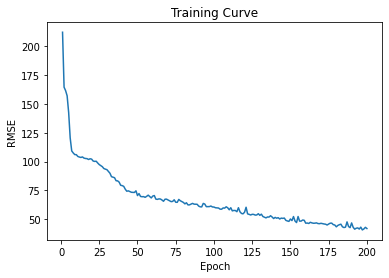

54/54 [==============================] - 0s 1ms/step - loss: 15487.5791 - root_mean_squared_error: 124.4491


In [33]:
# Build Models ------------------------------------------------------------------

# New NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((65, )))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1))

train(model, train_x, train_y, val_x, val_y, test_x, test_y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               8448      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 12,849
Trainable params: 12,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
74/74 [==============================] - 1s 6ms/step - loss: 54956.4305 - root_mean_squared_error: 233.9697 - val_loss: 27126.7012 - val_root_mean_squared_error: 164.7019

Epoch 00001: saving model to drive/MyDrive/Classes/CSCE_5300_Big

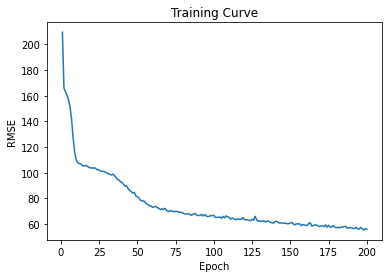

54/54 [==============================] - 0s 2ms/step - loss: 15334.7715 - root_mean_squared_error: 123.8336


In [34]:
# New NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((65, )))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1))

train(model, train_x, train_y, val_x, val_y, test_x, test_y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                

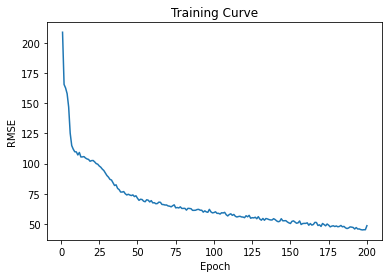

54/54 [==============================] - 0s 2ms/step - loss: 15353.3584 - root_mean_squared_error: 123.9087


In [35]:
# New NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((65, )))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1))

train(model, train_x, train_y, val_x, val_y, test_x, test_y)

In [36]:
# New SVM
model = SVR(kernel="poly", degree=2)
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
score = mean_squared_error(val_y, preds, squared=False)
score

166.21693368269916

In [37]:
# New SVM
model = SVR(kernel="poly", degree=3)
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

166.33629288475058


In [38]:
# New SVM
model = SVR(kernel="rbf")
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

167.16542992444352


In [39]:
# New SVM
model = SVR(kernel="linear")
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

119.87773930528263
73.40393927326556


In [40]:
# New Logistic Regression
model = LogisticRegression(penalty="l2")
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

219.8479620795192
197.70590275048556


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
# New Bayesian Regression
model = BayesianRidge()
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

105.15431752009381
58.031075674982304


In [42]:
# New Bayesian Regression
model = BayesianRidge(fit_intercept=False)
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

105.15377135483018


In [43]:
# New SGD Regressor
model = SGDRegressor()
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

1893637.1384092304
5798791.654136513


In [44]:
# New Lasso Regressor
model = Lasso()
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

108.0647639482104
59.74876675942794


In [45]:
# New ElasticNet Regressor
model = ElasticNet()
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

153.8545097127873
121.32999250901904


In [46]:
# New Ridge Regressor
model = Ridge()
model.fit(train_x, [x[0] for x in train_y])
preds = model.predict(val_x)
print(mean_squared_error(val_y, preds, squared=False))

preds = model.predict(test_x)
score = mean_squared_error(test_y, preds, squared=False)
print(score)

# WINNER

105.15270958373269
58.027485797131234


# Create Output File

In [61]:
test_x = pd.read_csv("test_luc.csv")

test_x["month"] = test["datetime"].apply(get_month)
test_x["day"] = test["datetime"].apply(get_day)
test_x["hour"] = test["datetime"].apply(get_hour)
test_x["windchill"] = test.apply(get_windchill, axis=1)
test_x["heat_idx"] = test_x.apply(get_heat_index, axis=1)

cols = ["month", "day", "hour", "weather"]
vals = test_x[cols]
vals = enc.transform(vals.to_numpy())
encoded = pd.DataFrame(vals.toarray(), columns=enc.get_feature_names(cols))
test_x = pd.concat([test_x, encoded], axis=1)
test_x.drop(cols, axis=1, inplace=True)
test_x["humidity"] = test_x["humidity"].apply(scale)

# New Ridge Regressor
model = Ridge()
model.fit(train_x, [x[0] for x in train_y])

cols = list(test_x.columns)
idx = cols.index("datetime")
cols = cols.remove("datetime")
test_y = []
for i, row in test_x.iterrows():
    dt = row["datetime"]
    count = model.predict([row.drop("datetime").to_numpy()])
    test_y.append([dt, count[0]])

test_y = pd.DataFrame(test_y, columns=["datetime", "count"])
test_y.to_csv("my_predictions.csv", index=False, header=True)
test_y

,datetime,count
0,2011-01-17 00:00:00,-49.263377
1,2011-01-17 01:00:00,-62.977759
2,2011-01-17 02:00:00,-80.753900
3,2011-01-17 03:00:00,-80.354908
4,2011-01-17 04:00:00,-73.895968
...,...,...
1707,2012-12-19 19:00:00,322.902964
1708,2012-12-19 20:00:00,228.267516
1709,2012-12-19 21:00:00,164.096275
1710,2012-12-19 22:00:00,149.109577
